In [1]:
import numpy
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

In [ ]:
#!pip install --upgrade tensorflow

In [2]:
# Set random seed for purposes of reproducibility
seed = 21

In [3]:
from keras.datasets import cifar10
# loading in the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

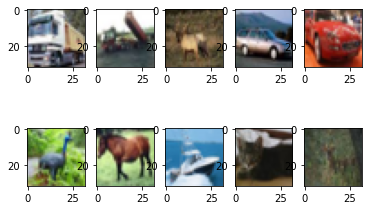

In [4]:
import matplotlib.pyplot as plt
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(X_train[i])

In [5]:
# normalize the inputs from 0-255 to between 0 and 1 by dividing by 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [7]:
model = Sequential()
# Первый слой нашей модели - это сверточный слой. Он будет принимать входные данные и пропускать их через сверточные фильтры.
# количество каналов (фильтров) 32, размер фильтра 3 x 3, форма входа (при создании первого слоя), функция активации и отступы.
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))

# исключающий слой для предотвращения переобучения, который случайным образом устраняет соединения между слоями 
# (0,2 означает, что он отбрасывает 20% существующих соединений):
model.add(Dropout(0.2))

# Пакетная нормализация нормализует входные данные, поступающие в следующий слой, гарантируя, 
# что сеть всегда создает функции активации с тем же распределением, которое нам нужно:
model.add(BatchNormalization())

# Еще один сверточный слой, но размер фильтра увеличивается, так что сеть уже может изучать более сложные представления:
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))

# Объединяющий слой, который, помогает сделать классификатор изображений более корректным
# чтобы он мог изучать релевантные шаблоны. Также опишем исключение (Dropout) и пакетную нормализацию:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Повторяем эти слои, чтобы дать вашей сети больше представлений для работы:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Cжимаем данные. Также добавим слой исключения снова:
model.add(Flatten())
model.add(Dropout(0.2))

# Bспользуем импортированную функцию Dense и создаем первый плотно связанный слой. 
# Нам нужно указать количество нейронов в плотном слое. 
# Обратите внимание, что число нейронов в последующих слоях уменьшается, 
# в конечном итоге приближаясь к тому же числу нейронов, что и классы в наборе данных (в данном случае 10). 
# Ограничение ядра может упорядочить данные в процессе обучения, что также помогает предотвратить переобучение. 
model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Функция активации softmax выбирает нейрон с наибольшей вероятностью в качестве своего выходного значения, 
# предполагая, что изображение принадлежит именно этому классу:
model.add(Dense(class_num))
model.add(Activation('softmax'))
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [8]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer= 'Adam', 
    metrics=['accuracy']                                                     
    )

In [9]:
numpy.random.seed(seed)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
782/782 [==============================] - 417s 531ms/step - loss: 1.4175 - accuracy: 0.4998 - val_loss: 1.2611 - val_accuracy: 0.5650
Epoch 2/5
782/782 [==============================] - 369s 472ms/step - loss: 0.9699 - accuracy: 0.6593 - val_loss: 1.1465 - val_accuracy: 0.5829
Epoch 3/5
782/782 [==============================] - 319s 407ms/step - loss: 0.8417 - accuracy: 0.7055 - val_loss: 0.8148 - val_accuracy: 0.7161
Epoch 4/5
782/782 [==============================] - 321s 411ms/step - loss: 0.7905 - accuracy: 0.7219 - val_loss: 0.7207 - val_accuracy: 0.7498
Epoch 5/5
782/782 [==============================] - 324s 414ms/step - loss: 0.7546 - accuracy: 0.7355 - val_loss: 0.7468 - val_accuracy: 0.7424


In [10]:
# Model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 74.24%


In [11]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model identical to the previous one
#model = load_model('my_model.h5')